# 1. Loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import glob
from multiprocessing import Pool, cpu_count
from loguru import logger
import plotly.graph_objects as go
from IPython.display import HTML, display
import collections


paths

In [2]:
# Define the path to aggregated data directory
script_dir = os.path.dirname(os.path.abspath('__file__'))
aggregated_dir = os.path.join(script_dir, '..', '..', 'aggregated')
appended_dir = os.path.join(script_dir, '..', '..', 'appended')
metadata_dir = os.path.join(script_dir, '..', '..', 'metadata')

aggregated data

In [3]:
agg_5min = pd.read_csv(os.path.join(aggregated_dir, 'aggregated_5min.csv'))
agg_15min = pd.read_csv(os.path.join(aggregated_dir, 'aggregated_15min.csv'))

metadata

In [4]:
metadata = pd.read_csv(os.path.join(metadata_dir, 'Metrics registration.csv'))

raw appended data (for comparison)

In [5]:
original_appended_data = pd.read_csv(os.path.join(appended_dir, 'excl_noon_reports.csv'))

In [6]:
# in the quantity_name column, add a parenthesis with the provider name (if the qid starts with 4) or the unit (if the qid starts with anything else)
original_appended_data['quantity_name'] = original_appended_data.apply(
    lambda row: f"{row['quantity_name']} ({row['source_name']})" if str(row['qid_mapping']).startswith('4') else f"{row['quantity_name']} ({row['unit']})",
    axis=1
)

In [7]:
original_appended_data.head()

,utc_timestamp,qid_mapping,value,quantity_name,source_name,unit,time_delta_sec
0,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::3::0_8,-0.4000,Vessel External Conditions Eastward Sea Water ...,Provider S,m/s,NaN
1,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_56::0::4::0_8,0.0000,Vessel External Conditions Northward Sea Water...,Provider MB,m/s,NaN
2,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_45::0::1::0_8,2.7000,Vessel External Conditions Wave Significant He...,Provider MB,m,NaN
3,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::5::0_8,0.5391,Vessel External Conditions Eastward Wind Veloc...,Provider S,m/s,NaN
4,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_2::0::15::21_8,79.0000,Vessel External Conditions Wind True Angle (Pr...,Provider MB,degrees,NaN


In [8]:
agg_15min.head()

,seg_id,window_start,Vessel Hull Over Ground Speed (knots),Vessel Hull Through Water Longitudinal Speed (knots),Vessel External Conditions Wind Relative Speed (knots),Vessel External Conditions Wind Relative Angle (degrees),Vessel Hull Heading True Angle (degrees),Vessel Hull Heading Turn Rate (deg/min),Main Engine Turbocharger Rotational Speed (rpm),Main Engine Scavenging Air Pressure (bar),...,Vessel External Conditions Sea Water Temperature (Provider S),Vessel External Conditions Eastward Sea Water Velocity (Provider MB),Vessel External Conditions Wave Period (Provider S),Vessel External Conditions Wind True Speed (Provider MB),Vessel External Conditions Northward Sea Water Velocity (Provider S),Vessel External Conditions Wave Significant Height (Provider S),Vessel External Conditions Northward Wind Velocity (Provider S),Fwd Draft (Noon Report),Mid Draft (Noon Report),Aft Draft (Noon Report)
0,10,2024-01-04 08:00:00+00:00,12.401552,12.101586,11.754294,325.919954,280.839555,-0.503367,12880.453469,1.493730,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
1,10,2024-01-04 08:15:00+00:00,12.047663,11.757108,11.586808,323.342038,280.867806,-0.167328,12860.939563,1.482888,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
2,10,2024-01-04 08:30:00+00:00,12.104065,12.112681,14.249752,326.192385,281.261508,0.219511,12952.960206,1.513493,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
3,10,2024-01-04 08:45:00+00:00,12.559796,12.478206,15.209066,328.105649,281.005681,-0.020980,13003.071058,1.530807,...,19.4928,0.00,1.7847,6.36,0.0464,0.1488,4.0150,10.19,10.19,10.19
4,10,2024-01-04 09:00:00+00:00,12.015313,11.570251,16.717556,332.168885,280.892922,-0.067982,12935.236188,1.505670,...,19.6822,0.03,1.6988,4.76,0.0702,0.1046,3.7707,10.19,10.19,10.19


In [9]:
metadata.head()

,qid_mapping,quantity_name,source_name,unit
0,3::0::1::0_1::1::0::2::0_11::0::2::0_8,Vessel Hull Aft Draft,Control Alarm Monitoring System,m
1,3::0::1::0_1::1::0::2::0_11::0::1::0_8,Vessel Hull Fore Draft,Control Alarm Monitoring System,m
2,3::0::1::0_1::2::0::8::0_1::0::6::0_8,Main Engine Rotational Speed,Control Alarm Monitoring System,rpm
3,3::0::1::0_1::1::0::2::0_11::0::3::0_8,Vessel Hull MidP Draft,Control Alarm Monitoring System,m
4,3::0::1::0_1::1::0::2::0_11::0::4::0_8,Vessel Hull MidS Draft,Control Alarm Monitoring System,m


In [10]:
# convert utc_timestamp to datetime
agg_5min['window_start'] = pd.to_datetime(agg_5min['window_start'], format='ISO8601', utc=True)
agg_15min['window_start'] = pd.to_datetime(agg_15min['window_start'], format='ISO8601', utc=True)
original_appended_data['utc_timestamp'] = pd.to_datetime(original_appended_data['utc_timestamp'], format='ISO8601', utc=True)

# 2. Initial checks

## 2.1. Distributions

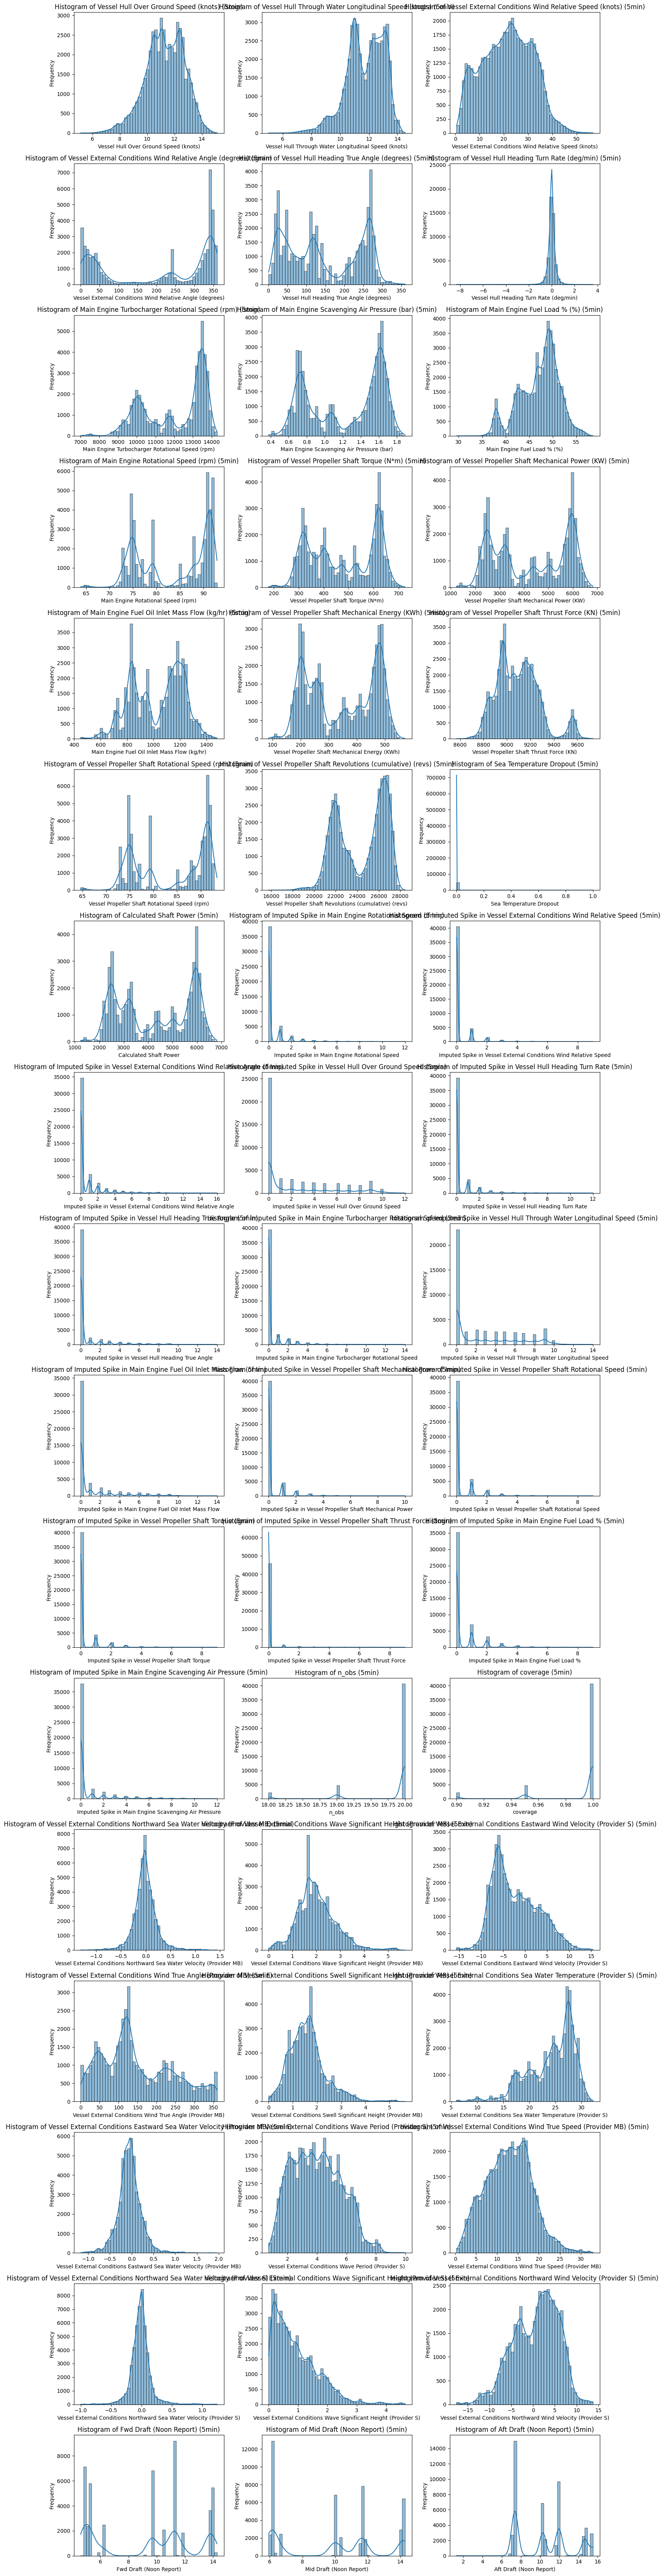

In [8]:
# Make a histogram for each column except window start and seg_id
cols = [col for col in agg_5min.columns if col not in ['window_start', 'seg_id']]
n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(cols):
    sns.histplot(agg_5min[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Histogram of {col} (5min)')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide unused subplots
for idx in range(len(cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 2.2. Line graphs

In [51]:
def plot_variable_comparison(
    agg_dfs: list[tuple[pd.DataFrame, str]],
    raw_df: pd.DataFrame,
    variable: str,
    start_time: str | pd.Timestamp | None = None,
    end_time: str | pd.Timestamp | None = None,
    ax: plt.Axes | None = None,
    show_legend: bool = False,
) -> plt.Axes:
    # Create axes only if not provided
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 4))

    palette = sns.color_palette("tab10")

    # Normalize time bounds once
    if start_time is not None:
        start_time = pd.to_datetime(start_time, utc=True)
    if end_time is not None:
        end_time = pd.to_datetime(end_time, utc=True)

    # --- Raw data ---
    raw_var = raw_df.loc[raw_df["quantity_name"] == variable, ["utc_timestamp", "value"]]
    if start_time is not None:
        raw_var = raw_var[raw_var["utc_timestamp"] >= start_time]
    if end_time is not None:
        raw_var = raw_var[raw_var["utc_timestamp"] <= end_time]

    ax.plot(
        raw_var["utc_timestamp"], raw_var["value"],
        color=palette[0], linewidth=0.8, alpha=0.5, label="Raw",
    )

    # --- Aggregated data ---
    for i, (agg_df, label) in enumerate(agg_dfs):
        if variable not in agg_df.columns:
            continue

        agg_slice = agg_df.loc[:, ["window_start", variable]].dropna(subset=[variable])

        if start_time is not None:
            agg_slice = agg_slice[agg_slice["window_start"] >= start_time]
        if end_time is not None:
            agg_slice = agg_slice[agg_slice["window_start"] <= end_time]

        ax.plot(
            agg_slice["window_start"], agg_slice[variable],
            color=palette[(i + 1) % len(palette)], linewidth=1.2, label=label,
        )

    ax.set_title(variable, fontsize=9)
    ax.legend()
    ax.tick_params(axis="x", labelsize=7, labelrotation=30)
    ax.tick_params(axis="y", labelsize=7)

    if show_legend:
        ax.legend(fontsize=7)

    return ax

def plot_variables_grid(
    agg_dfs,
    raw_df,
    variables,
    start_time=None,
    end_time=None,
    n_cols: int = 3,
    row_height: float = 3.5,
    shared_legend: bool = True,
    close: bool = True,   # <- key for "no double display" in notebooks
):
    n = len(variables)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, row_height * n_rows),
        squeeze=False,
    )

    for idx, var in enumerate(variables):
        r, c = divmod(idx, n_cols)
        plot_variable_comparison(
            agg_dfs, raw_df, var,
            start_time=start_time, end_time=end_time,
            ax=axes[r][c],
            show_legend=(not shared_legend and idx == 0),
        )

    for idx in range(n, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].set_visible(False)

    fig.tight_layout()

    if close:
        plt.close(fig)  # prevents automatic notebook rendering [web:89]

    return fig

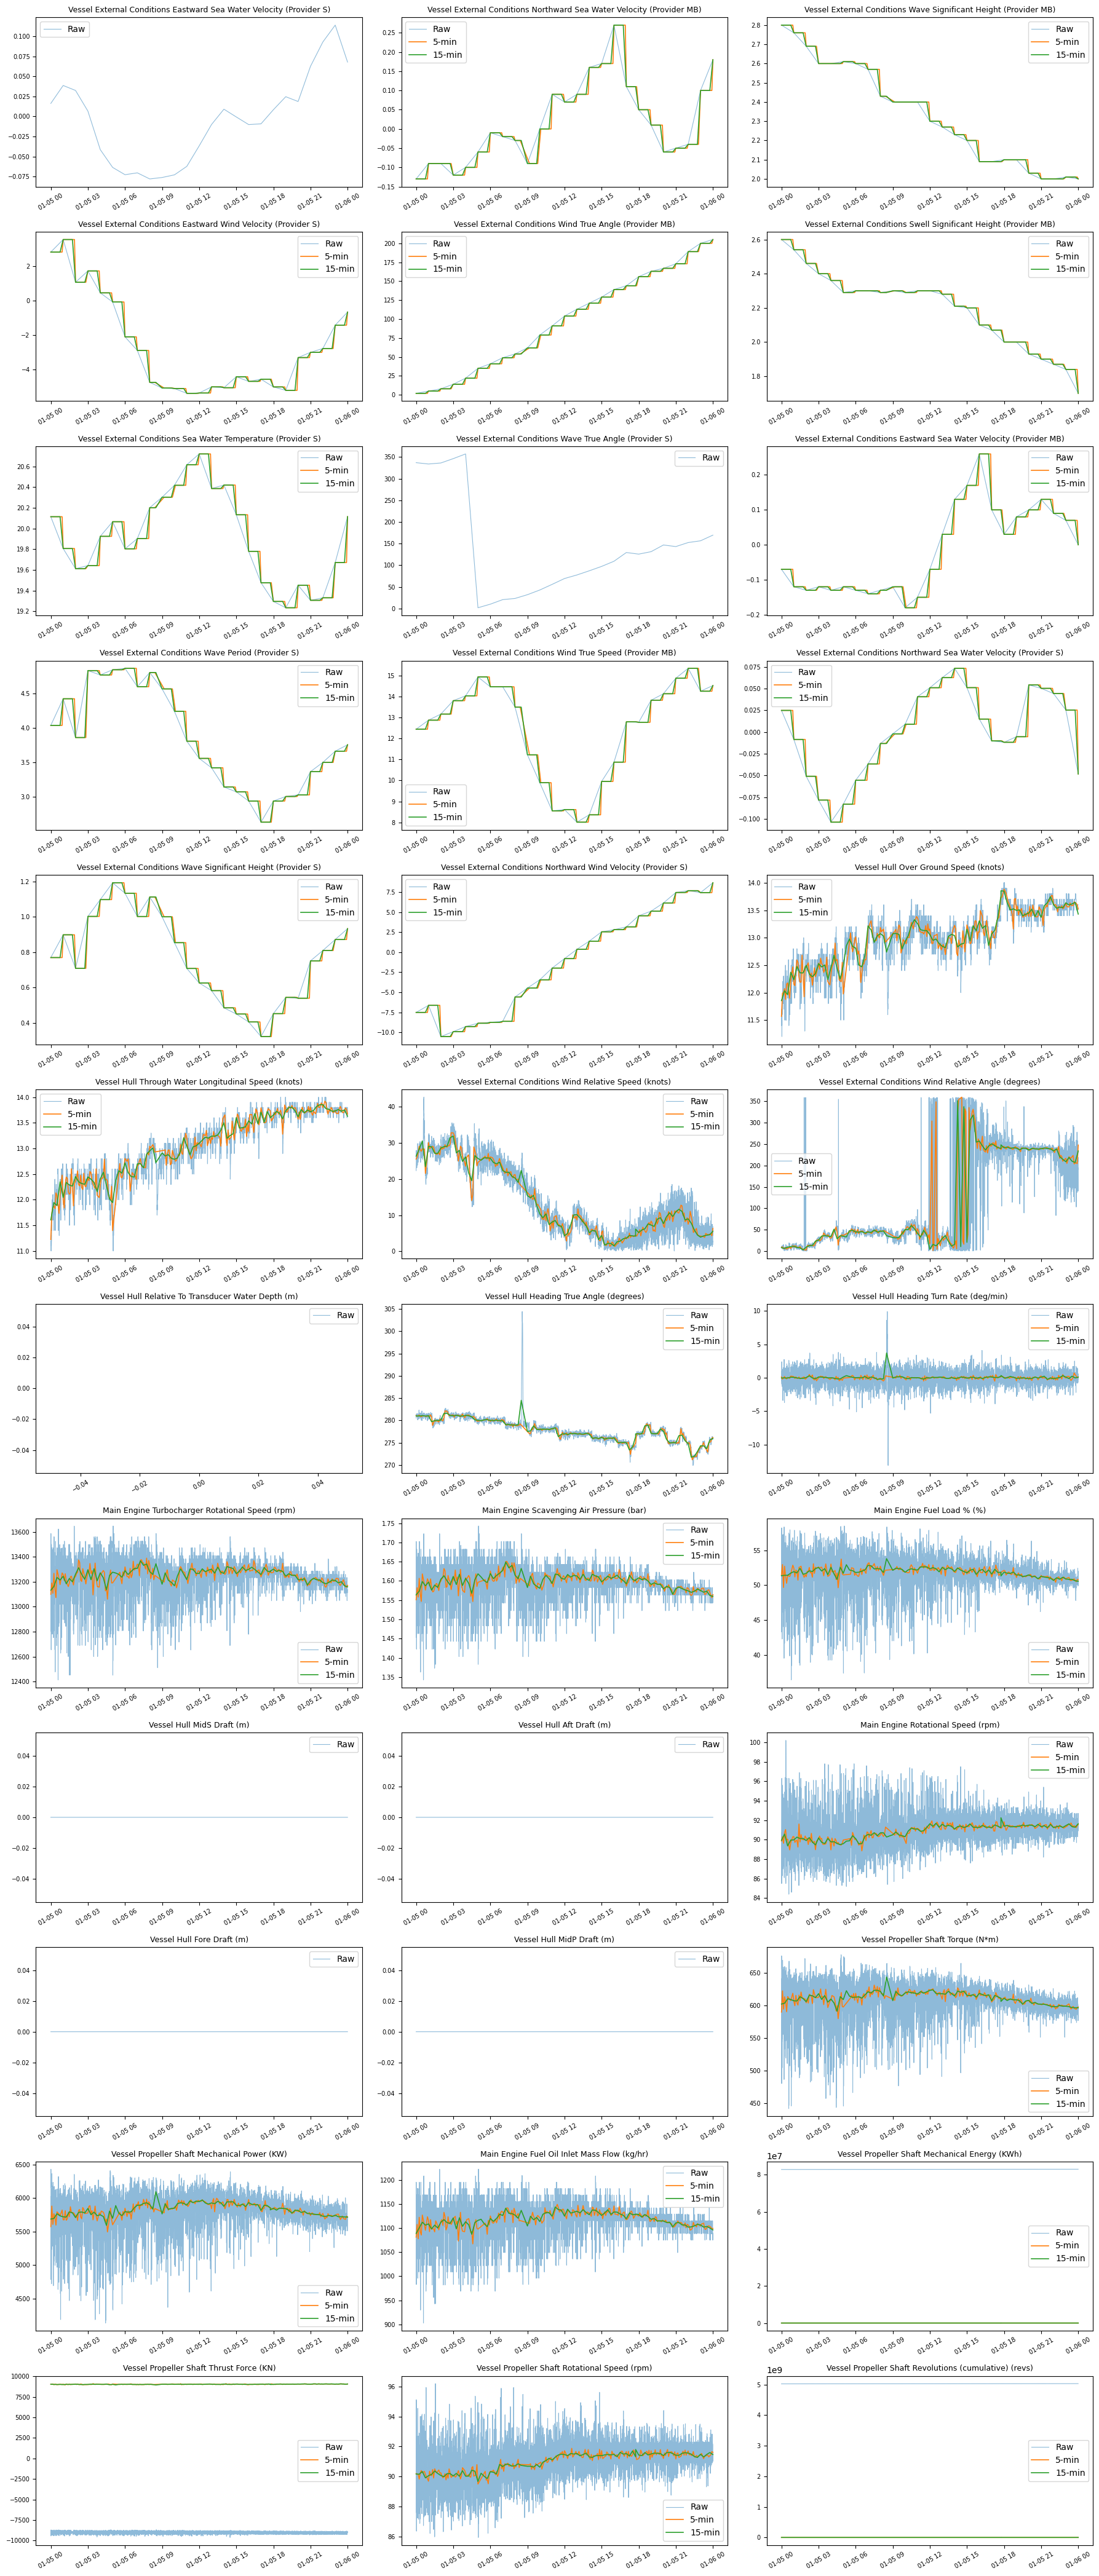

In [52]:
variables_to_plot = original_appended_data['quantity_name'].unique()

start_time = pd.to_datetime("2024-01-05 00:00:00", utc=True)
end_time = pd.to_datetime("2024-01-06 00:00:00", utc=True)

fig = plot_variables_grid(
    agg_dfs = [(agg_5min, '5-min'), (agg_15min, '15-min')],
    raw_df =  original_appended_data,
    variables = variables_to_plot,
    start_time = start_time,
    end_time = end_time,
)

fig

## 2.3. Derive cleaning events

In [55]:
agg_5min.info()

<class 'pandas.DataFrame'>
RangeIndex: 47597 entries, 0 to 47596
Data columns (total 53 columns):
 #   Column                                                                 Non-Null Count  Dtype              
---  ------                                                                 --------------  -----              
 0   seg_id                                                                 47597 non-null  int64              
 1   window_start                                                           47597 non-null  datetime64[us, UTC]
 2   Vessel Hull Over Ground Speed (knots)                                  47597 non-null  float64            
 3   Vessel Hull Through Water Longitudinal Speed (knots)                   47597 non-null  float64            
 4   Vessel External Conditions Wind Relative Speed (knots)                 47597 non-null  float64            
 5   Vessel External Conditions Wind Relative Angle (degrees)               47597 non-null  float64            
 6   V

In [ ]:
agg_5min['Speed / Power (knots/KW)'] = agg_5min['Vessel Hull Over Ground Speed (knots)'] / agg_5min['Vessel Propeller Shaft Mechanical Power (KW)']
agg_5min['']

In [74]:
def plot_jan_jul_comparison(
    df: pd.DataFrame,
    variable: str,
    comp_variables: list[str] | None = None,
) -> plt.Figure:
    df = df.copy()
    df["month"] = df["window_start"].dt.month

    if comp_variables:
        df[comp_variables] = df[comp_variables].fillna(0)  # <- added

    periods = {
        "Jan – Feb": df[df["month"].isin([1, 2])],
        "Jul – Aug": df[df["month"].isin([7, 8])],
    }

    palette = sns.color_palette("tab10")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, (title, data) in zip(axes, periods.items()):
        # --- Primary variable (left y-axis) ---
        sns.lineplot(
            x="window_start", y=variable, data=data,
            ax=ax, color=palette[0], linewidth=1.2, label=variable,
        )
        ax.set_title(title, fontsize=10)
        ax.set_xlabel("Time")
        ax.tick_params(axis="x", labelrotation=30, labelsize=7)
        ax.tick_params(axis="y", labelsize=7)

        # --- Comparison variables (right y-axis) ---
        if comp_variables:
            ax2 = ax.twinx()
            for i, comp_var in enumerate(comp_variables):
                sns.lineplot(
                    x="window_start", y=comp_var, data=data,
                    ax=ax2, color=palette[i + 1], linewidth=1.0,
                    alpha=0.5, label=comp_var,
                )
            ax2.set_ylabel(", ".join(comp_variables), fontsize=7)
            ax2.tick_params(axis="y", labelsize=7)

            handles1, labels1 = ax.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(handles1 + handles2, labels1 + labels2, fontsize=7)
            if ax2.get_legend():
                ax2.get_legend().remove()
        else:
            ax.legend(fontsize=7)

    axes[0].set_ylabel(variable, fontsize=8)
    axes[1].set_ylabel("")

    fig.suptitle(variable, fontsize=11, y=1.01)
    fig.tight_layout()
    plt.close(fig)
    return fig

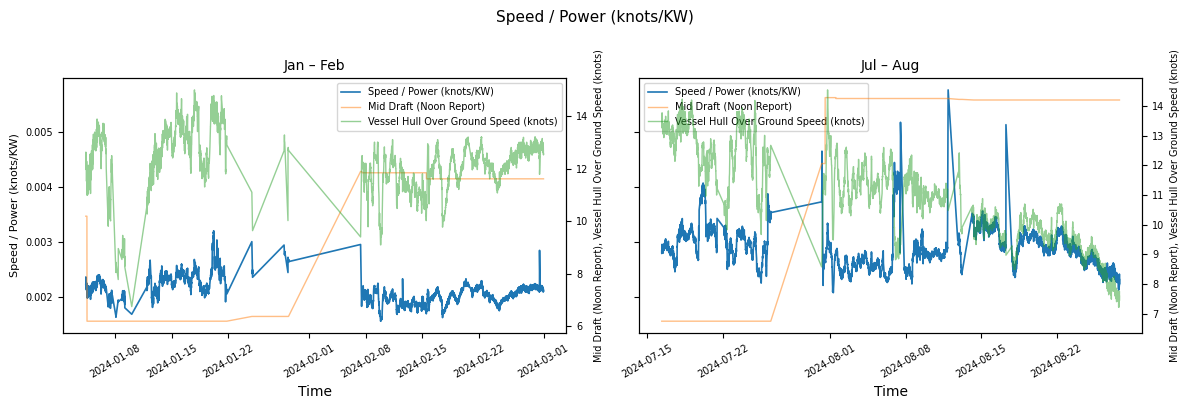

In [75]:
plot_jan_jul_comparison(agg_5min, variable='Speed / Power (knots/KW)', comp_variables=['Mid Draft (Noon Report)', 'Vessel Hull Over Ground Speed (knots)'])

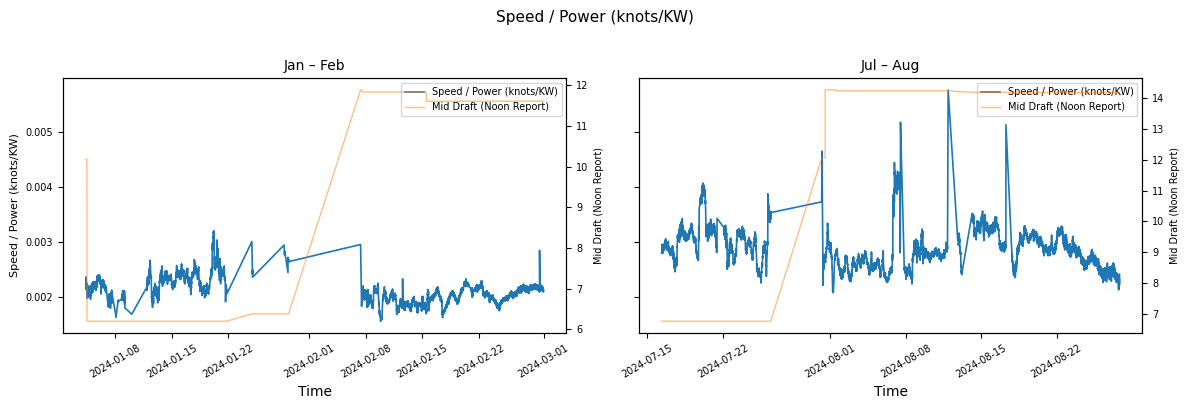

: 

In [ ]:
plot_jan_jul_comparison(agg_5min, variable='Speed / Power (knots/KW)', comp_variables=['Mid Draft (Noon Report)'])

## 2.4. Correlation matrix

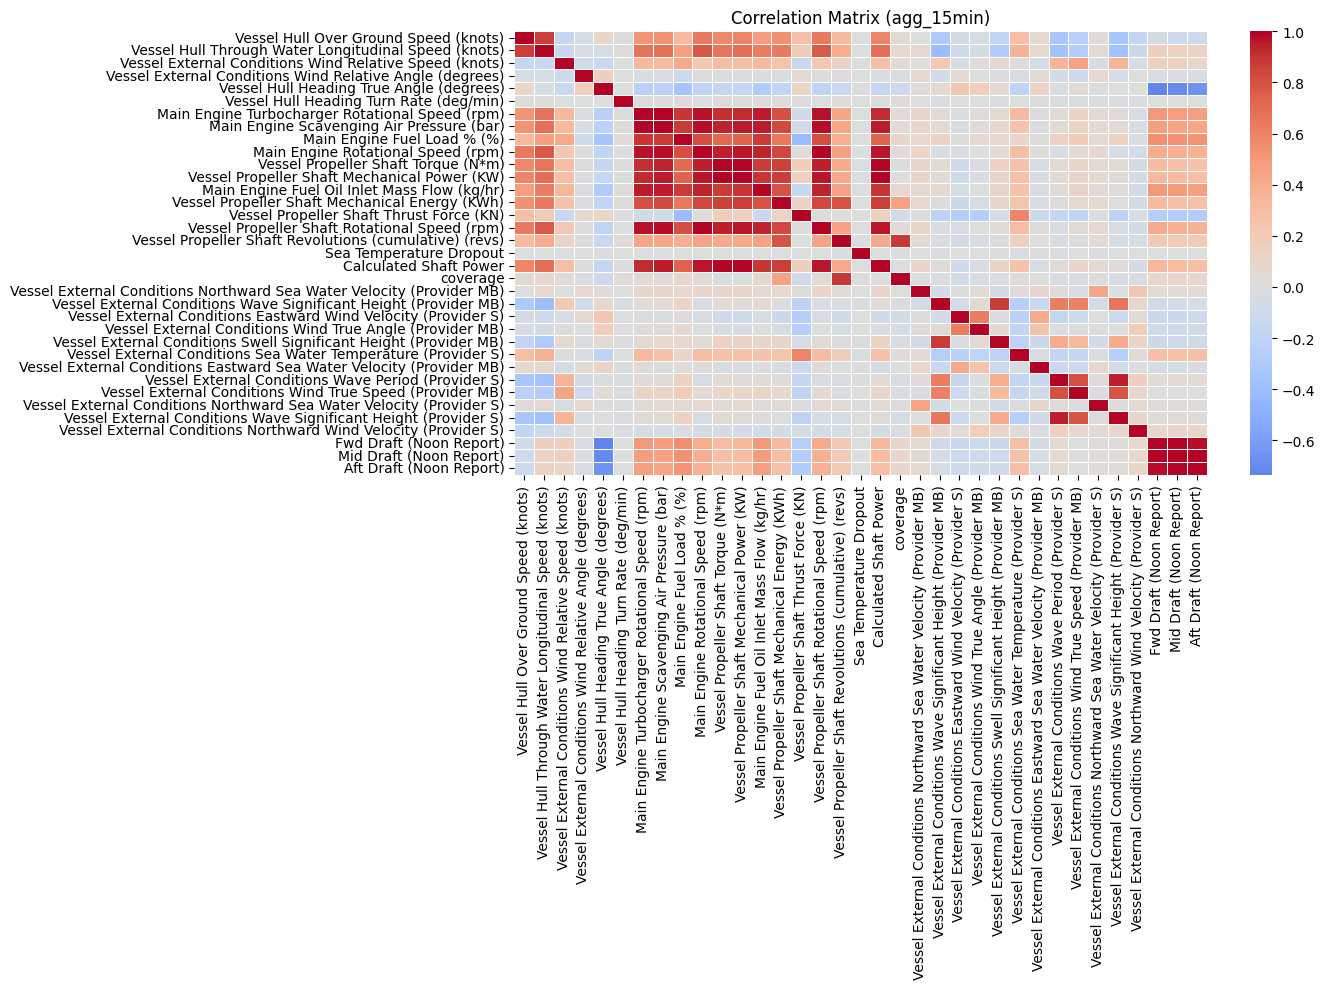

In [12]:
columns_to_exclude = [col for col in agg_15min.columns if col.startswith(('window_start', 'seg_id', 'n_obs', 'Imputed'))]

# Make a correlation matrix for the agg_15min dataframe
corr = agg_15min.drop(columns=columns_to_exclude).select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix (agg_15min)")
plt.tight_layout()
plt.show()


## 2.5. Dummy speed-poper curves for different drafts

In [ ]:
# Create draft buckets and fit power law curves for each
df = agg_15min.copy()
df = df.dropna(subset=['Mid Draft (Noon Report)', 'Vessel Hull Through Water Longitudinal Speed (knots)', 'Vessel Propeller Shaft Mechanical Power (KW)'])

# Define draft buckets
draft_bins = [0, 8, 9, 10, 11, 15]
draft_labels = ['<8m', '8-9m', '9-10m', '10-11m', '>11m']
df['draft_bucket'] = pd.cut(df['Mid Draft (Noon Report)'], bins=draft_bins, labels=draft_labels)

# Create scatter plot with power law fits
fig, ax = plt.subplots(figsize=(12, 6))
palette = sns.color_palette("husl", len(draft_labels))

for idx, (bucket, color) in enumerate(zip(draft_labels, palette)):
    bucket_data = df[df['draft_bucket'] == bucket]
    
    if len(bucket_data) > 0:
        x = bucket_data['Vessel Hull Through Water Longitudinal Speed (knots)'].values
        y = bucket_data['Vessel Propeller Shaft Mechanical Power (KW)'].values
        
        # Plot scatter
        ax.scatter(x, y, alpha=0.3, s=10, color=color, label=bucket)
        
        # Fit power law: y = a * x^b
        if len(x) > 1 and (x > 0).all() and (y > 0).all():
            coeffs = np.polyfit(np.log(x), np.log(y), 1)
            b, log_a = coeffs[0], coeffs[1]
            a = np.exp(log_a)
            
            # Plot fitted curve
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = a * (x_fit ** b)
            ax.plot(x_fit, y_fit, color=color, linewidth=2, label=f'{bucket}: P = {a:.1f}·v^{b:.2f}')

ax.set_xlabel('Vessel Hull Through Water Longitudinal Speed (knots)', fontsize=10)
ax.set_ylabel('Vessel Propeller Shaft Mechanical Power (KW)', fontsize=10)
ax.set_title('Speed-Power Curves by Draft Bucket', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.6. Torque vs power

Matthew: There are some points where the torque doesn’t agree with the power at all when resampling, so I should check my exploration again after resampling


In [ ]:
agg_15min['Calculated Shaft Power (Post Aggregation)'] = (agg_15min['Vessel Propeller Shaft Torque (N*m)'] * agg_15min['Vessel Propeller Shaft Rotational Speed (rpm)'] * 2 * np.pi) / 60

# Scatter plot of calculated shaft power vs reported shaft power
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x='Calculated Shaft Power (Post Aggregation)',
    y='Vessel Propeller Shaft Mechanical Power (KW)',
    data=agg_15min,
    alpha=0.5, s=20
)
ax.plot([0, agg_15min['Calculated Shaft Power (Post Aggregation)'].max()], [0, agg_15min['Calculated Shaft Power (Post Aggregation)'].max()], color='red', linestyle='--')
ax.set_xlabel('Calculated Shaft Power (KW)', fontsize=10)
ax.set_ylabel('Reported Shaft Power (KW)', fontsize=10)
ax.set_title('Calculated vs Reported Shaft Power', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
